## COVID-19 time series analysis
time series data from https://github.com/CSSEGISandData  
Weidong Yang  
2020-03-01

In [39]:
# init code
%matplotlib inline 

import pandas as pd
import matplotlib.pyplot as plt
import math
import string
from datetime import date

def parse_column(str):
    if str=='Long': # GraphXR recognize lat and lon as geo location data
        return 'Lon'
    elif str[0].isdigit():
        year=str.split('/')[2]
        month=str.split('/')[0]
        day=str.split('/')[1]
        return '2020-'+month.zfill(2)+'-'+day.zfill(2)
    else:
        return str
    

## Generate log(case) over time and sum(death) over the past 3 days

In [52]:
# Load Total Cases over time
d_case=pd.read_csv('data/time_series_19-covid-Confirmed.csv')

d_case.columns=[parse_column(x) for x in d_case.columns]
dates=[d for d in d_case.columns if d[0].isdigit()]
countries = d_case.shape[0]

for d in dates:
    d_case[d] = pd.to_numeric(d_case[d], downcast='float')

# Calculate increase of cases each day
d_new_case=d_case[['Province/State', 'Country/Region', 'Lat', 'Lon']].copy()

for i in range(0, len(dates)-1):
    d_new_case[dates[i+1]] = d_case[dates[i+1]]-d_case[dates[i]]

# convert to log10 for scaling
d_new_case_log = d_new_case.copy()

for d in dates[1:]:
    d_new_case_log[d] = d_new_case[d].apply(lambda x: math.log10(max(x, 0)+1))


# Process Death
d_death = pd.read_csv('data/time_series_19-covid-Deaths.csv')
d_death.columns=[parse_column(x) for x in d_death.columns]

dates=[d for d in d_death.columns if d[0].isdigit()]

for d in dates:
    d_death[d] = pd.to_numeric(d_death[d], downcast='float')

# Death rate, number death during past 3 days
d_new_case_log['death_per_100_case'] = d_death[dates[-1]] / d_case[dates[-1]] * 100
d_new_case_log['death_past_3_days']=d_death[dates[-1]] - d_death[dates[-4]]


# Save to folder and to be loaded into GraphXR project
d_new_case.to_csv('output/new_confirmed.csv', index=False)


# Process Recover
d_recover = pd.read_csv('data/time_series_19-covid-Recovered.csv')
d_recover.columns=[parse_column(x) for x in d_recover.columns]

dates=[d for d in d_recover.columns if d[0].isdigit()]

for d in dates:
    d_recover[d] = pd.to_numeric(d_recover[d], downcast='float')

## Each date, location is a node

In [53]:
# create by date data

d_death_stat=d_death.melt(id_vars=["Province/State", "Country/Region", "Lat", "Lon"], 
        var_name="Date", 
        value_name="Death")

d_case_stat=d_case.melt(id_vars=["Province/State", "Country/Region", "Lat", "Lon"], 
        var_name="Date", 
        value_name="Cases")

d_recover_stat=d_recover.melt(id_vars=["Province/State", "Country/Region", "Lat", "Lon"], 
        var_name="Date", 
        value_name="Recovered")

d_stat = pd.merge(d_case_stat, d_death_stat, on = ['Lat', 'Lon', 'Province/State', 'Country/Region', 'Date'])
d_stat = pd.merge(d_stat, d_recover_stat, on = ['Lat', 'Lon', 'Province/State', 'Country/Region', 'Date'])

d_stat['Cases_log']=d_stat['Cases'].apply(lambda x: math.log10(x+1))
d_stat['Death_log']=d_stat['Death'].apply(lambda x: math.log10(x+1))
d_stat['Recovered_log']=d_stat['Recovered'].apply(lambda x: math.log10(x+1))

d_stat=d_stat[d_stat['Cases']>0]
d_stat.to_csv('output/regionStat.csv', index=False)

## Compare China and outside of China

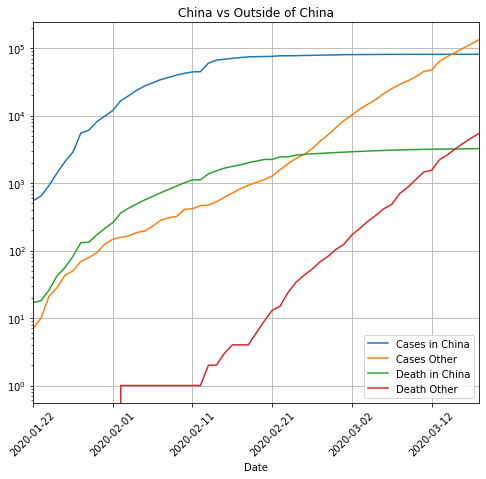

In [59]:
d_stat['IsChina']=d_stat['Country/Region'].apply(lambda x: 'China' if x == 'China' else 'Other')
d_grouped = d_stat.groupby(['IsChina', 'Date'])['Cases', 'Death', 'Recovered'].sum().reset_index()

fig, ax1 = plt.subplots()

d_grouped.pivot(index='Date', columns = 'IsChina', values = ['Cases', 'Death']).plot(
    ax = ax1, logy=True, rot=45, 
    figsize=(8, 7), grid=True, title="China vs Outside of China")
ax1.legend(['Cases in China', 'Cases Other', 'Death in China', 'Death Other'])

fig.savefig("output/china vs other.png")

## Company Death, Accumulated Cases and Case Fatality Ratio among countries

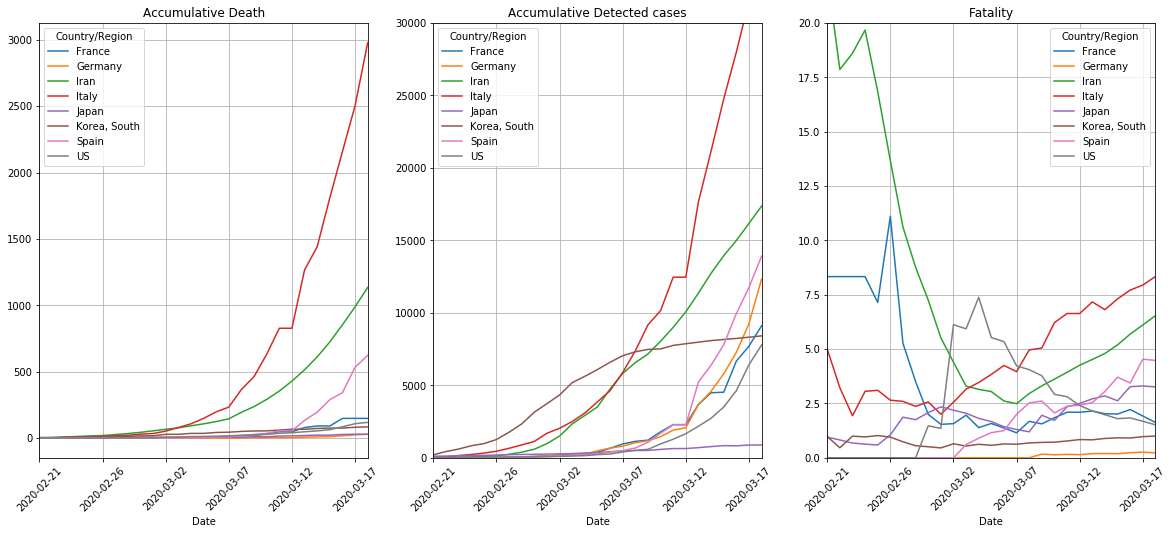

In [61]:
d_country_stat = d_stat.groupby(['Country/Region', 'Date'])['Cases', 'Death', 'Recovered'].sum().reset_index()

d_country_stat['DeathPer100Cases']=d_country_stat['Death']/d_country_stat['Cases']*100

d_temp = d_country_stat[d_country_stat['Country/Region'].isin(['Italy', 'US',
    'Korea, South', 'Iran', 'Japan', 'Spain', 'Germany', 'France'])] 

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
# fig, (ax1, ax2) = plt.subplots(1, 2)

d_temp[d_temp['Date']>'2020-02-20'] \
.pivot(index='Date', columns='Country/Region', values='Death') \
.plot(ax = ax1, rot=45, grid=True, figsize=(20, 8), title='Accumulative Death')

d_temp[d_temp['Date']>'2020-02-20'] \
.pivot(index='Date', columns='Country/Region', values='Cases') \
.plot(ax = ax2, rot=45, grid=True, figsize=(20, 8), title='Accumulative Detected cases', ylim=(0, 30000))

d_temp[d_temp['Date']>'2020-02-20'] \
.pivot(index='Date', columns='Country/Region', values='DeathPer100Cases') \
.plot(ax = ax3, rot=45, grid=True, figsize=(20, 8), title='Fatality', ylim=(0, 20))



# fig = the_plot.get_figure()
fig.savefig("output/cases_vs_death_timeline.png")

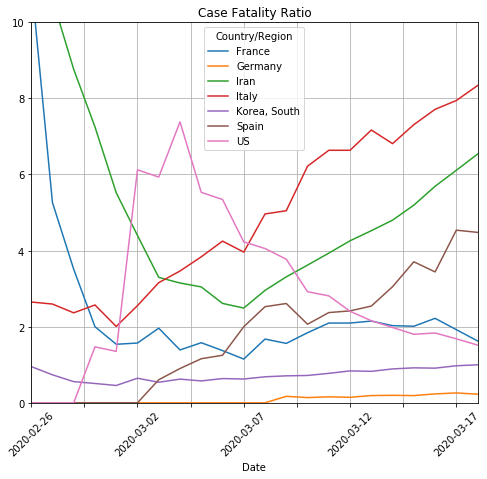

In [63]:
d_temp = d_country_stat[d_country_stat['Country/Region'].isin(['Italy', 'US',
    'Korea, South', 'Iran', 'Spain', 'France', 'Germany'])] 

fig, ax = plt.subplots()
d_temp[d_temp['Date']>'2020-02-25'] \
.pivot(index='Date', columns='Country/Region', values='DeathPer100Cases') \
.plot(ax = ax, rot=45, grid=True, figsize=(8, 7), title='Case Fatality Ratio', ylim=(0, 10))

fig.savefig("output/fatality_trend.png")

In [64]:
lastDay = d_country_stat[(d_country_stat['Date']==dates[-1]) & (d_country_stat['Death']>20)].copy()

lastDay['FatalityRate']=lastDay['DeathPer100Cases'].apply(lambda x: str(x)[0:4]+'%')
lastDay['Cases_log']=lastDay['Cases'].apply(lambda x: math.log(x))
lastDay['Death_log']=lastDay['Death'].apply(lambda x: math.log(x))
lastDay

lastDay.to_csv('output/latest fatality rate.csv', index=False)

## Align by onset date

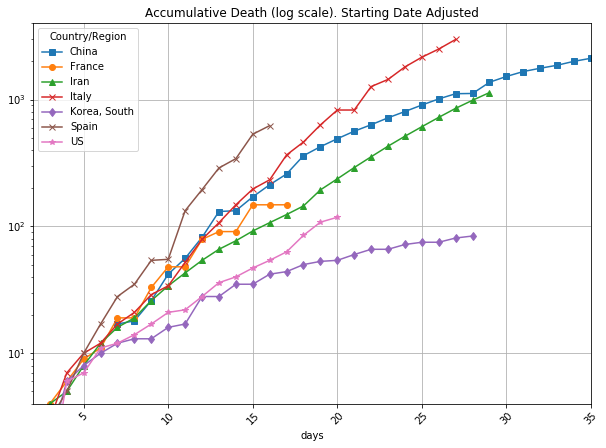

In [70]:
d_start_date=pd.DataFrame([
    ['China', '2020-01-15'],     
    ['France', '2020-03-01'],     
    ['Iran', '2020-02-18'],
    ['Italy', '2020-02-20'], 
    ['Korea, South', '2020-02-19'],
    ['Spain', '2020-03-02'], 
    ['US', '2020-02-27']   
], columns = ['Country/Region', 'StartDate'])

d_compare = d_country_stat[d_country_stat['Country/Region'].isin(['China', 'Italy', 'Korea, South', 'US', 'Iran', 'Spain', 'France'])]
d_death_growth = d_compare.groupby(['Country/Region', 'Date'])['Death'].sum().reset_index()
d_death_growth = pd.merge(d_death_growth, d_start_date, on='Country/Region')

d_death_growth['days'] = d_death_growth.apply(lambda x: 
    (date(*map(int, x['Date'].split('-'))) - date(*map(int, x['StartDate'].split('-')))).days, axis = 1)

fig, ax = plt.subplots()

the_plot = d_death_growth[(d_death_growth['days']>2) & (d_death_growth['days']<230) ]\
.pivot(index='days', columns='Country/Region', values='Death') \
.plot(ax = ax, rot=45, grid=True, figsize=(10, 7), style=['s-','o-','^-', 'x-', 'd-', 'x-', '*-'], 
      logy=True, ylim=(4, 4000), xlim=(2, 35),
      title='Accumulative Death (log scale). Starting Date Adjusted', label=['aa'])

# ax.legend(list(d_start['Country/Region'] + '--' + d_start['StartDate']))

fig = the_plot.get_figure()

fig.savefig("output/accumulative_death.png")

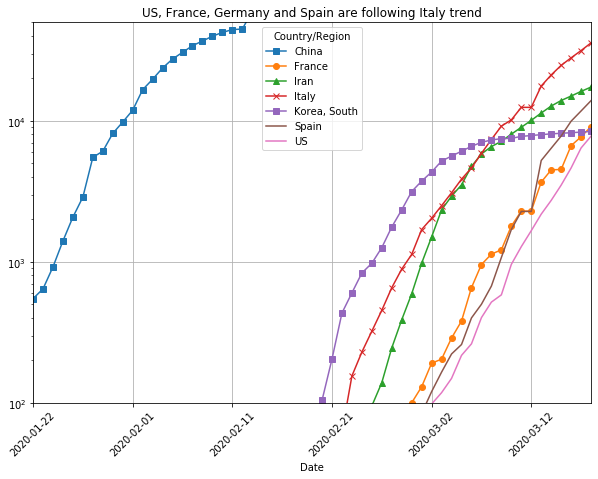

In [74]:
d_cases_growth = d_compare.groupby(['Country/Region', 'Date'])['Cases'].sum().reset_index()

fig, ax = plt.subplots()

the_plot = d_cases_growth[d_cases_growth['Date']>'2020-01-10'].pivot(index='Date', columns='Country/Region', values='Cases') \
.plot(ax = ax, rot=45, grid=True, figsize=(10, 7), style=['s-','o-','^-', 'x-', 's-'], logy=True, ylim=[100, 50000],
      title='US, France, Germany and Spain are following Italy trend')

fig.savefig("output/following italy.png")

## Compare selected countries, Death, Cases, CFR

In [80]:
d_country_stat=d_compare.groupby(['Country/Region', 'Date'])['Cases', 'Death'].sum().reset_index()
d_country_stat=pd.merge(d_country_stat, d_start_date, on='Country/Region')
d_country_stat['days'] = d_country_stat.apply(lambda x: 
    (date(*map(int, x['Date'].split('-'))) - date(*map(int, x['StartDate'].split('-')))).days, axis = 1)
d_country_stat['CasesLog']=d_country_stat['Cases'].apply(lambda x: math.log(x+1))
d_country_stat['DeathLog']=d_country_stat['Death'].apply(lambda x: math.log(x+1))
d_country_stat['CFR']=d_country_stat.apply(lambda x: x['Death']/(x['Cases']+0.0001), axis = 1)

d_country_stat.to_csv('output/country_stat.csv', index=False)